In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(42)

species_of_interest = ["@H2SIO", "H", "H2", "O", "C", "N", "CL", "E-", "CO", "MG", "#C", "H2O", "SI", 'SURFACE', 'BULK', 'C+', '@C', '@O', '#O']
physical_params = ['density', 'gasTemp', 'av', 'radField']

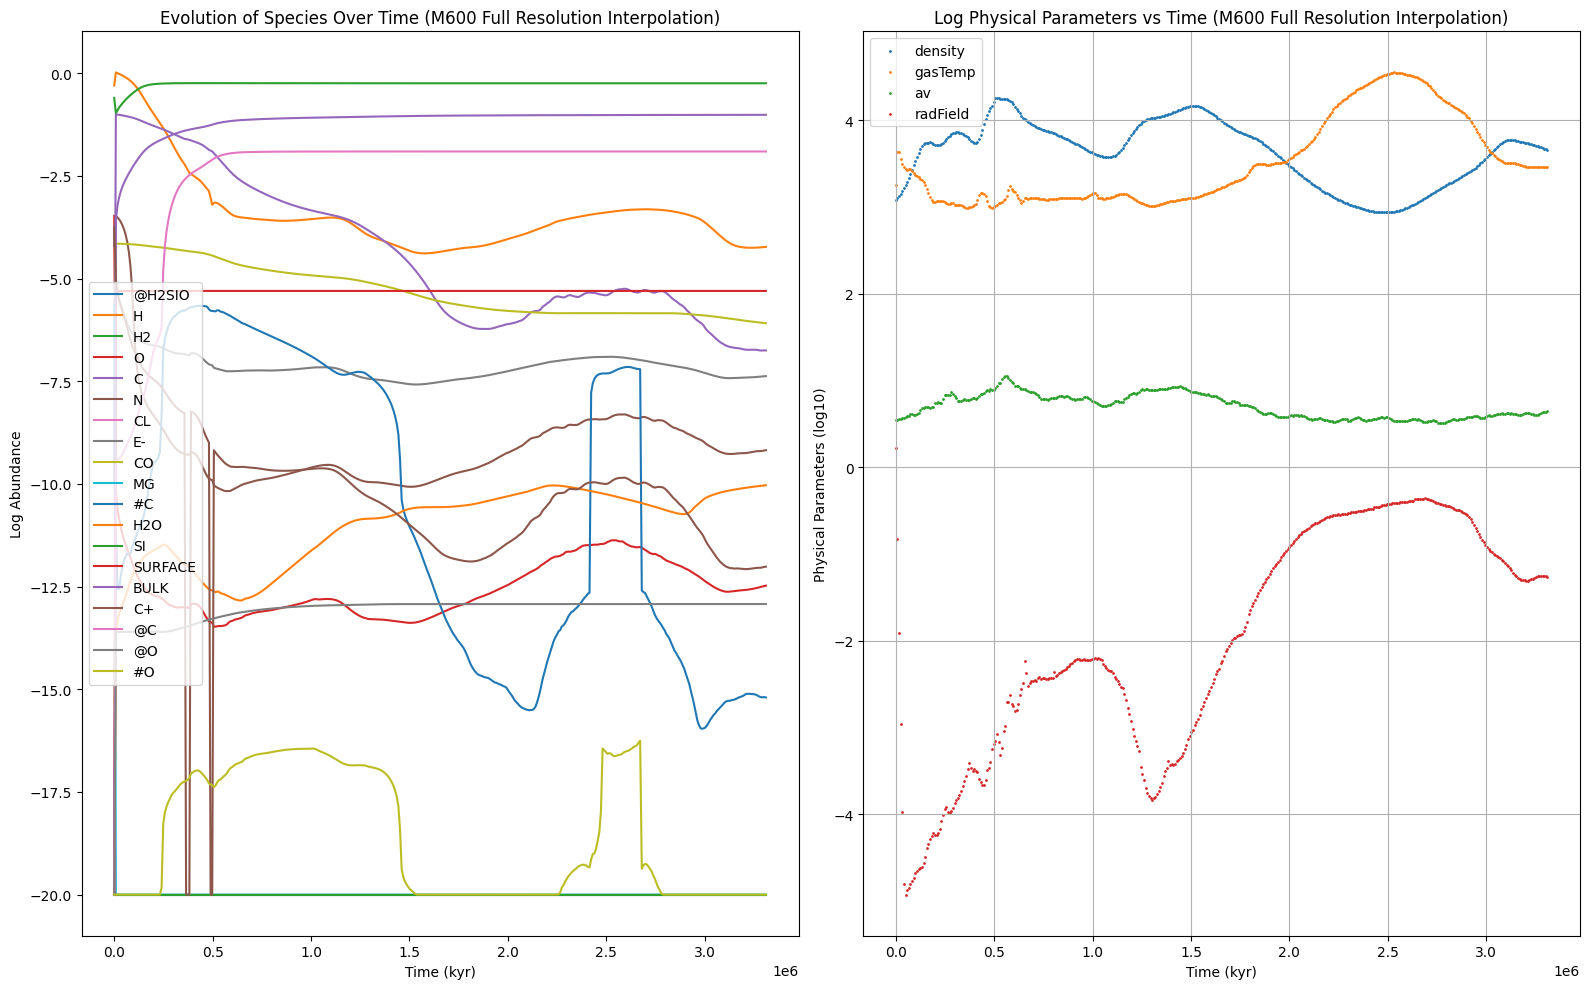

In [22]:
df = pd.read_csv('data/chemistry_tracers_csv/M600_1_1_Tracer_10.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

for species in species_of_interest:
    if species in df.columns:
        log_abundance = np.log10(df[species].replace(0, np.nan))
        log_abundance = np.maximum(log_abundance, -20)
        ax1.plot(df['time'], log_abundance, label=species)

ax1.set_xlabel('Time (kyr)')
ax1.set_ylabel('Log Abundance')
ax1.set_title('Evolution of Species Over Time (M600 Full Resolution Interpolation)')
ax1.legend()

for param in physical_params:
    if param in df.columns:
        y = pd.to_numeric(np.log10(df[param]), errors='coerce')
        if param == 'gasTemp':
            y *= 3
        ax2.scatter(df['time'], y, label=param, s=1)

ax2.set_xlabel('Time (kyr)')
ax2.set_ylabel('Physical Parameters (log10)')
ax2.set_title('Log Physical Parameters vs Time (M600 Full Resolution Interpolation)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [9]:
def compare_log10_differences(df1, df2):
    common_cols = df1.columns.intersection(df2.columns)
    df1, df2 = df1[common_cols], df2[common_cols]
    
    log_df1 = np.log10(df1.where(df1 > 0))
    log_df2 = np.log10(df2.where(df2 > 0))
    
    log_df1 = log_df1.clip(lower=-25)
    log_df2 = log_df2.clip(lower=-25)
    
    diffs = (log_df1 - log_df2).abs()
    
    col_diffs = diffs.mean().sort_values(ascending=False)
    
    return col_diffs, diffs

Mean differences: 0.020405223731474933
Max differences: 16.72379891832309


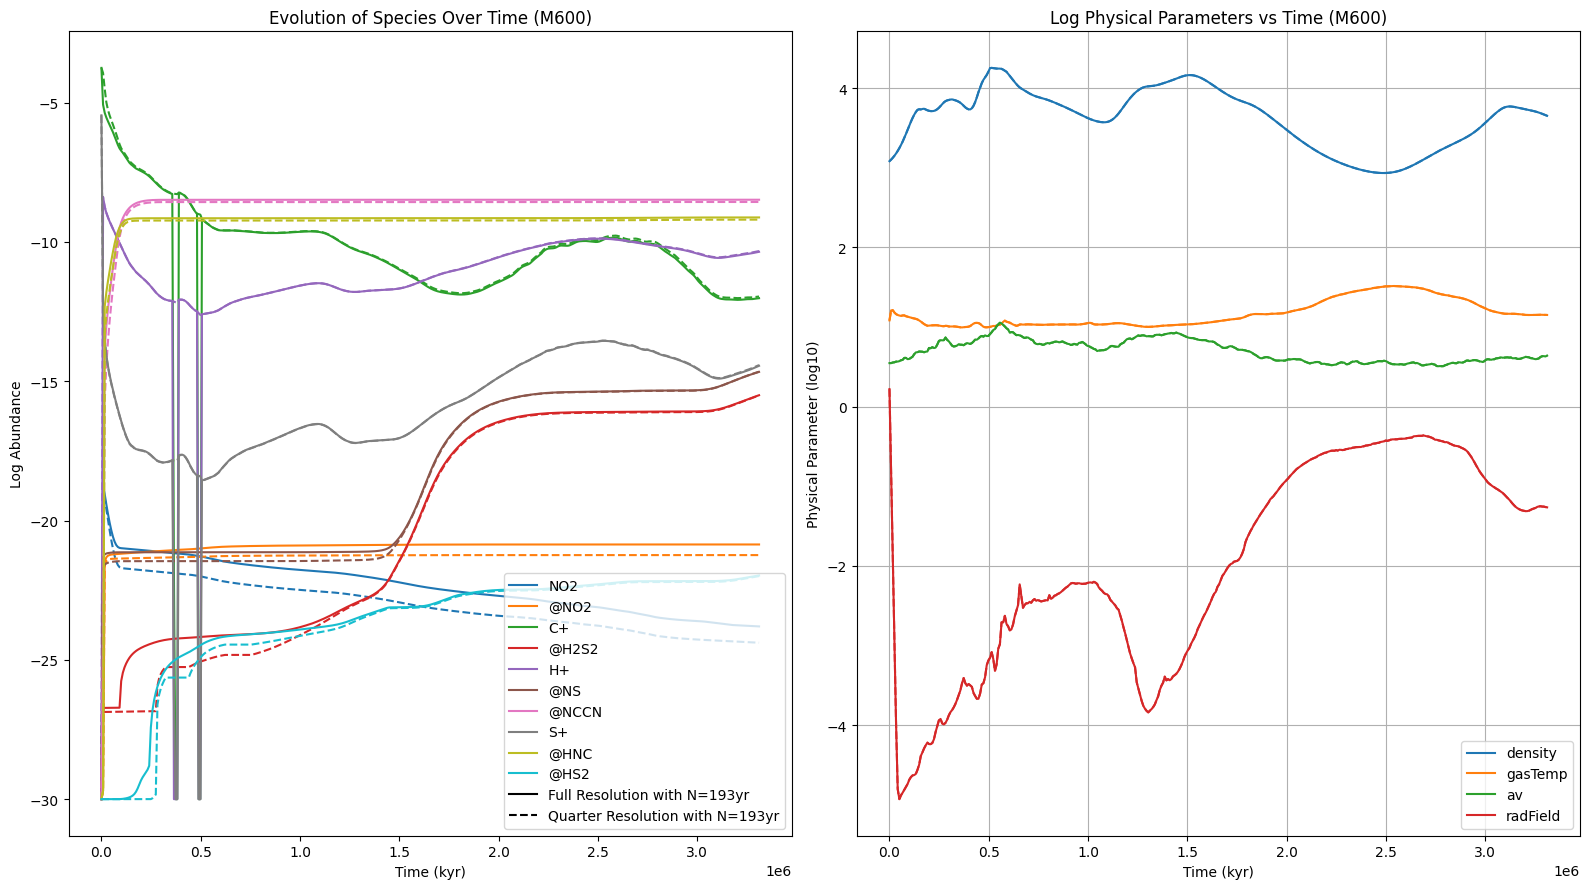

In [12]:
df1 = pd.read_csv('data/reactions_information/M600_1_1_Tracer_10_9.csv')
df2 = pd.read_csv('data/chemistry_tracers_csv/M600_1_1_Tracer_10.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

colors = plt.cm.tab10.colors

col_diffs, diffs = compare_log10_differences(df1, df2)
print(f"Mean differences: {diffs.mean().mean()}")
print(f"Max differences: {diffs.max().max()}")
species_of_interest = col_diffs[:10].index

for i, species in enumerate(species_of_interest):
    color = colors[i % len(colors)]
    log_abundance1 = np.log10(df1[species].replace(0, np.nan))
    log_abundance2 = np.log10(df2[species].replace(0, np.nan))
    log_abundance1 = np.maximum(log_abundance1, -30)
    log_abundance2 = np.maximum(log_abundance2, -30)

    ax1.plot(df1['time'], log_abundance1, label=f"{species}", color=color)
    ax1.plot(df2['time'], log_abundance2, color=color, linestyle='--')

ax1.plot([], [], color='black', label='Full Resolution with N=193yr')
ax1.plot([], [], linestyle='--', color='black', label='Quarter Resolution with N=193yr')
#ax1.set_ylim(-30, -25)
ax1.set_xlabel('Time (kyr)')
ax1.set_ylabel('Log Abundance')
ax1.set_title('Evolution of Species Over Time (M600)')
ax1.legend()

for i, param in enumerate(physical_params):
    color = colors[i % len(colors)]
    p1 = pd.to_numeric(np.log10(df1[param]), errors='coerce')
    p2 = pd.to_numeric(np.log10(df2[param]), errors='coerce')
    ax2.plot(df1['time'], p1, label=f"{param}", color=color)
    ax2.plot(df2['time'], p2, color=color, linestyle='--')

ax1.plot([], [], linestyle='--', color='black', label='Quarter Resolution')
ax2.set_xlabel('Time (kyr)')
ax2.set_ylabel('Physical Parameter (log10)')
ax2.set_title('Log Physical Parameters vs Time (M600)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [14]:
x = os.listdir('data/chemistry_tracers_csv/')
y = []
for file in x:
    y.append(int(file.replace('M600_1_1_Tracer_', '').replace('.csv', '')))

indices = list(sorted(set(y)))
print(indices)

[10, 216, 314, 2741, 3619, 4548, 5170, 5576, 8270, 8814, 8857, 9391, 9712, 10151, 13396, 14182, 15125, 15180, 15411, 15908, 19592, 20090, 21925, 25202, 27562, 29316, 30822, 31451, 31513, 31725, 31938]


In [ ]:
worst_errors = []

for ind in indices:
    try:
        df1 = pd.read_csv(f'data/chemistry_tracers_csv/M600_1_1_Tracer_{ind}.csv')
        df2 = pd.read_csv(f'data/chemistry_tracers_csv/M600_1_1_Tracer_{ind}_.csv')
    except:
        continue

    merged = pd.merge(df1, df2, on="time", suffixes=("_df1", "_df2"))

    log_relative_errors = {}
    for col in df1.columns:
        if col == "time" or col in physical_params:
            continue
        col_df1 = col + "_df1"
        col_df2 = col + "_df2"
        
        log_df1 = np.log(merged[col_df1].replace(0, np.nan))
        log_df2 = np.log(merged[col_df2].replace(0, np.nan))
        
        log_df1 = np.maximum(log_df1, -20)
        log_df2 = np.maximum(log_df2, -20)
        
        log_rel_error = np.abs(log_df1 - log_df2)
        log_relative_errors[col] = log_rel_error.mean()

    result = pd.DataFrame.from_dict(log_relative_errors, orient="index", columns=["Mean Log-Relative Error"])
    result = result.sort_values(by="Mean Log-Relative Error", ascending=False)

    worst_errors.append(([ind, result['Mean Log-Relative Error'].mean()]))

In [ ]:
print(sorted(worst_errors, key=lambda x: x[1]))

In [ ]:
species_of_interest = result.iloc[:10].index.tolist()

In [ ]:
df1 = pd.read_csv('data/chemistry_tracers_csv/M600_1_1_Tracer_10.csv')
df2 = pd.read_csv('data/chemistry_tracers_csv/M600_1_1_Tracer_10_.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

colors = plt.cm.tab10.colors

for i, species in enumerate(species_of_interest):
    color = colors[i % len(colors)]
    log_abundance1 = np.log10(df1[species].replace(0, np.nan))
    log_abundance2 = np.log10(df2[species].replace(0, np.nan))
    log_abundance1 = np.maximum(log_abundance1, -20)
    log_abundance2 = np.maximum(log_abundance2, -20)

    ax1.plot(df1['time'], log_abundance1, label=f"{species}", color=color)
    ax1.plot(df2['time'], log_abundance2, color=color, linestyle='--')

ax1.plot([], [], color='black', label='Full Resolution')
ax1.plot([], [], linestyle='--', color='black', label='Quarter Resolution')
ax1.set_xlabel('Time (kyr)')
ax1.set_ylabel('Log Abundance')
ax1.set_title('Evolution of Species Over Time (M600)')
ax1.legend()
ax1.grid(True)

for i, param in enumerate(physical_params):
    color = colors[i % len(colors)]
    p1 = pd.to_numeric(np.log10(df1[param]), errors='coerce')
    p2 = pd.to_numeric(np.log10(df2[param]), errors='coerce')
    ax2.plot(df1['time'], p1, label=f"{param}", color=color)
    ax2.plot(df2['time'], p2, color=color, linestyle='--')

ax1.plot([], [], linestyle='--', color='black', label='Quarter Resolution')
ax2.set_xlabel('Time (kyr)')
ax2.set_ylabel('Physical Parameters (log10)')
ax2.set_title('Log Physical Parameters vs Time (M600)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os

files = os.listdir('data/turbulence_tracers_csv')

to_remove = []

for file in files:
    if "_1_" in file:
        os.rename(os.path.join('data/turbulence_tracers_csv', file), os.path.join('data/turbulence_tracers_csv', file.replace('1_11_', '1_1_')))